PyTorch Image Models (timm)を使ってみる

GitHub : https://github.com/rwightman/pytorch-image-models
- Document: https://github.com/rwightman/pytorch-image-models#getting-started-documentation

In [1]:
import numpy as np

import matplotlib.pyplot as plt 

from PIL import Image

import torch
from torchvision.io import read_image
from torchinfo import summary

import timm
from timm.data import resolve_data_config    # 事前学習モデルのデータ前処理情報
from timm.data.transforms_factory import create_transform   # 複数のTransformを連続して実施できる機能（前処理情報を用いる）

torch.__version__, timm.__version__

('1.12.1', '0.6.11')

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(194, 259, 3)


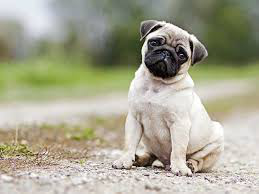

In [2]:
# 推論用テスト画像

img1 = Image.open("data/sample/dog1.jpeg")   # PIL.JpegImagePlugin.JpegImageFileとして画像を読み込む（timmのデータ処理パイプラインはこのフォーマットを指定）
#img1 = read_image("data/sample/dog1.jpeg")     # torch.Tensorとして画像を読み込む
print(type(img1))
print(np.array(img1).shape)    # numpyに変換し、次元の確認

img1

In [3]:
# 事前学習モデル一覧

print(len(timm.list_models(pretrained=True)))
timm.list_models(pretrained=True)[:10]

765


['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224']

#### 各事前学習モデルのパフォーマンス一覧: 
https://github.com/rwightman/pytorch-image-models/blob/main/results/README.md

### 事前学習モデルのロードと推論の実施

In [4]:
# 事前学習モデルのロード

m = timm.create_model('resnet50', pretrained=True)
m.eval()   # 推論モード

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

PyTorch内の事前学習モデルを利用する場合と同じ：
https://github.com/yukismd/DataScience_Tutorials/blob/main/PyTorch_learning/image_using_pretrained.ipynb

In [5]:
summary(m, (10,3,194,259))     #  (B,C,H,W)のサイズのデータを投入した場合の挙動

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 1000]                --
├─Conv2d: 1-1                            [10, 64, 97, 130]         9,408
├─BatchNorm2d: 1-2                       [10, 64, 97, 130]         128
├─ReLU: 1-3                              [10, 64, 97, 130]         --
├─MaxPool2d: 1-4                         [10, 64, 49, 65]          --
├─Sequential: 1-5                        [10, 256, 49, 65]         --
│    └─Bottleneck: 2-1                   [10, 256, 49, 65]         --
│    │    └─Conv2d: 3-1                  [10, 64, 49, 65]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 49, 65]          128
│    │    └─ReLU: 3-3                    [10, 64, 49, 65]          --
│    │    └─Conv2d: 3-4                  [10, 64, 49, 65]          36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 49, 65]          128
│    │    └─Identity: 3-6                [10, 64, 49, 65]          --
│ 

timm ResNet: https://rwightman.github.io/pytorch-image-models/models/resnet/

In [6]:
m.default_cfg   # モデル情報

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet50'}

In [7]:
m.num_classes   # 分類クラス数

1000

In [8]:
m.num_features   # CNN層の最終アウトプット

2048

In [9]:
# 推論データの前処理を実施する機能（事前学習モデルに利用した前処理情報を利用）

config = resolve_data_config({}, model=m)     # 事前学習モデルのデータ前処理情報
print(type(config))
print(config)

print('-----')

transform = create_transform(**config, is_training=False)    # 複数のTransformを連続して実施できる機能（Compose）
print(type(transform))
print(transform)

<class 'dict'>
{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.95}
-----
<class 'torchvision.transforms.transforms.Compose'>
Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [10]:
input_tensor = transform(img1).unsqueeze(0)     # 推論用データの変換

np.array(img1).shape, transform(img1).size(), input_tensor.size()     # 元データ  ->  変換  ->  バッチ次元を付与

((194, 259, 3), torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [11]:
# 推論の実施

res = m(input_tensor)   # 推論
print(res.size())    # 1000クラスへの分類結果
print(res[0][:10])   # 先頭10個

print('-----')

res_prob = torch.nn.functional.softmax(res[0], dim=0)
print(res_prob.size())
print(res_prob[:10]) # 1000クラスの所属確率

torch.Size([1, 1000])
tensor([ -9.4143, -11.0413, -10.9302, -10.9394, -11.8769,  -9.8519, -12.1574,
         -9.5076,  -9.6549, -10.5529], grad_fn=<SliceBackward0>)
-----
torch.Size([1000])
tensor([1.0613e-05, 2.0857e-06, 2.3309e-06, 2.3094e-06, 9.0434e-07, 6.8519e-06,
        6.8318e-07, 9.6680e-06, 8.3439e-06, 3.3989e-06],
       grad_fn=<SliceBackward0>)


In [12]:
res_prob.sum()   # 合計1

tensor(1.0000, grad_fn=<SumBackward0>)

In [13]:
class_id = res_prob.argmax().item()    # 予測確率が最大のインデックスを取得
score = res_prob[class_id].item()   # 予測確率
class_id, score

(254, 0.9468386769294739)

[Imagenetの1000カテゴリ](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)  
  
254 -> pug, pug-dog

### ファインチューニングなどに用いる場合。クラス数を指定して学習モデルをロード

In [14]:
m2 = timm.create_model('resnet50', pretrained=True, num_classes=2)   # クラス数を指定。二値分類の場合
m2.fc

Linear(in_features=2048, out_features=2, bias=True)

In [15]:
summary(m2, (10,3,194,259))     #  (B,C,H,W)のサイズのデータを投入した場合の挙動

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2]                   --
├─Conv2d: 1-1                            [10, 64, 97, 130]         9,408
├─BatchNorm2d: 1-2                       [10, 64, 97, 130]         128
├─ReLU: 1-3                              [10, 64, 97, 130]         --
├─MaxPool2d: 1-4                         [10, 64, 49, 65]          --
├─Sequential: 1-5                        [10, 256, 49, 65]         --
│    └─Bottleneck: 2-1                   [10, 256, 49, 65]         --
│    │    └─Conv2d: 3-1                  [10, 64, 49, 65]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 49, 65]          128
│    │    └─ReLU: 3-3                    [10, 64, 49, 65]          --
│    │    └─Conv2d: 3-4                  [10, 64, 49, 65]          36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 49, 65]          128
│    │    └─Identity: 3-6                [10, 64, 49, 65]          --
│ 

### Backboneとして利用する場合（Head部分を外す）

In [16]:
# Head部分の無効化

m3 = timm.create_model('resnet50', pretrained=True, 
                       num_classes=0)
m3.global_pool, m3.fc

(SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1)),
 Identity())

In [17]:
summary(m3, (10,3,194,259))     #  (B,C,H,W)のサイズのデータを投入した場合の挙動

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2048]                --
├─Conv2d: 1-1                            [10, 64, 97, 130]         9,408
├─BatchNorm2d: 1-2                       [10, 64, 97, 130]         128
├─ReLU: 1-3                              [10, 64, 97, 130]         --
├─MaxPool2d: 1-4                         [10, 64, 49, 65]          --
├─Sequential: 1-5                        [10, 256, 49, 65]         --
│    └─Bottleneck: 2-1                   [10, 256, 49, 65]         --
│    │    └─Conv2d: 3-1                  [10, 64, 49, 65]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 49, 65]          128
│    │    └─ReLU: 3-3                    [10, 64, 49, 65]          --
│    │    └─Conv2d: 3-4                  [10, 64, 49, 65]          36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 49, 65]          128
│    │    └─Identity: 3-6                [10, 64, 49, 65]          --
│ 

In [18]:
# Head部分の無効化（さらにGlobal Poolingも実施しない場合）

m4 = timm.create_model('resnet50', pretrained=True, 
                       num_classes=0,
                      global_pool='')   # さらにGlobal Poolingも実施しない場合
m4.global_pool, m4.fc

(SelectAdaptivePool2d (pool_type=, flatten=Identity()), Identity())

In [19]:
summary(m4, (10,3,194,259))     #  (B,C,H,W)のサイズのデータを投入した場合の挙動

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2048, 7, 9]          --
├─Conv2d: 1-1                            [10, 64, 97, 130]         9,408
├─BatchNorm2d: 1-2                       [10, 64, 97, 130]         128
├─ReLU: 1-3                              [10, 64, 97, 130]         --
├─MaxPool2d: 1-4                         [10, 64, 49, 65]          --
├─Sequential: 1-5                        [10, 256, 49, 65]         --
│    └─Bottleneck: 2-1                   [10, 256, 49, 65]         --
│    │    └─Conv2d: 3-1                  [10, 64, 49, 65]          4,096
│    │    └─BatchNorm2d: 3-2             [10, 64, 49, 65]          128
│    │    └─ReLU: 3-3                    [10, 64, 49, 65]          --
│    │    └─Conv2d: 3-4                  [10, 64, 49, 65]          36,864
│    │    └─BatchNorm2d: 3-5             [10, 64, 49, 65]          128
│    │    └─Identity: 3-6                [10, 64, 49, 65]          --
│ 

[ResNet50に関して](https://blog.devgenius.io/resnet50-6b42934db431)

In [20]:
# Backboneとして利用してHeadを自分で定義する場合

# Backbone
backbone = m3

# Head
head = torch.nn.Sequential(
    torch.nn.Linear(backbone.num_features, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(100, 10)
)

print(head)

def my_model(x):
    h = backbone(x)
    y = head(h)
    return y

Sequential(
  (0): Linear(in_features=2048, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=100, out_features=10, bias=True)
)


In [21]:
sample_data = torch.rand(2, 3,224,224)

my_model(sample_data).size()

torch.Size([2, 10])